## Выделение объектов из текста с помощью spacy (часть II)

генерируем текст (описание сцены) делаем его предобработку с момощью LLM (убираем эллипсисы, кореференсы, вложенные дополнения и тп) далее с помощью spacy выделяем объекты и признаки в формат, удобный для построения графа


**То, с чем не справляется spaCy делаем через LLM и далее уже идем эвристиками**

#### пример (разрешение эллипсиса)

Исходный текст: **На столе стояла белая ваза с цветами и синяя пустая. Стул находился перед вазой с цветами.Обе вазы выглядят очень дорого и стильно**


Нормализованный текст: **На столе стояла белая стильная дорогая ваза 1 с цветами и синяя пустая стильная дорогая ваза 2. Стул находился перед вазой 1 с цветами.**

```
Объекты: ['стол', 'ваза 1', 'цвет', 'ваза 2', 'стул']
Признаки: {'ваза 1': ['белая', 'дорогая', 'стильная'], 'ваза 2': ['дорогая', 'пустая', 'синяя', 'стильная']}
Отношения: [('ваза 1', 'на', 'стол'), ('ваза 1', 'с', 'цвет'), ('стул', 'перед', 'ваза 1'), ('ваза 1', 'с', 'цвет')]
```

#### пример графа, построенного по этому описанию

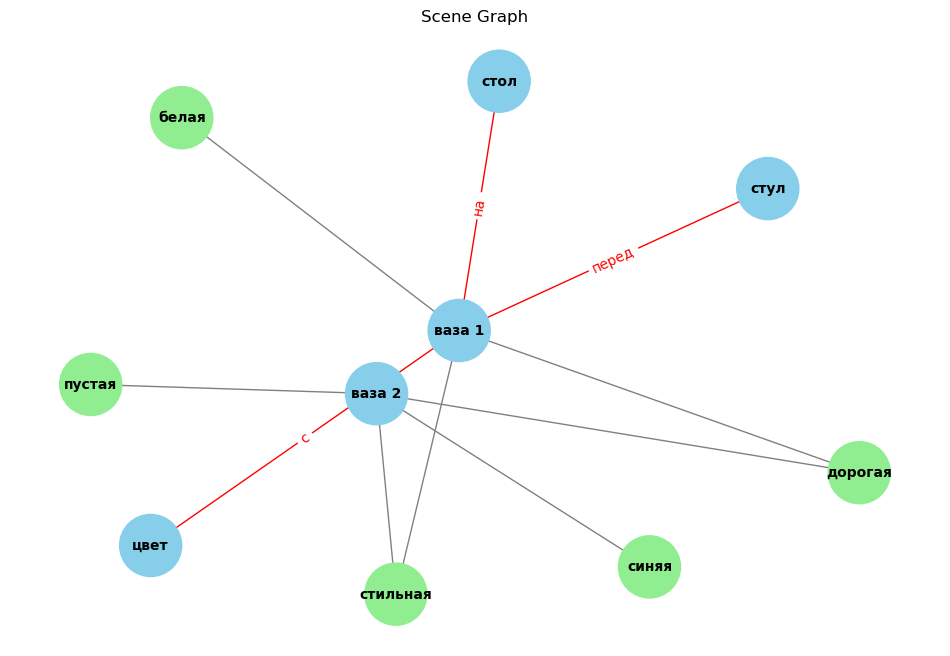

In [1]:
import os
import json
import time
import random
import spacy
import re

from spacy.matcher import Matcher, DependencyMatcher
from dotenv import load_dotenv
from tqdm import tqdm

from collections import Counter, defaultdict
from openai import OpenAI

import networkx as nx
import matplotlib.pyplot as plt

# можно ru_core_news_sm но она работает хуже
nlp = spacy.load("ru_core_news_lg")

load_dotenv()
API_KEY = os.getenv("API_KEY")

#print(API_KEY)

### Функции предобработки и разбора

#### Нормализация текста с помощью LLM

In [2]:
PROMPT = """
Ты — система нормализации описаний сцены.

Твоя задача — преобразовать текст сцены так, чтобы:

1. Все объекты (например, "ваза", "стул", "ящик", "цветы", "стол", "комната") были явно названы.
2. Если **один и тот же тип объекта упоминается более одного раза** (например, несколько ваз или стульев), 
   ты должен **нумеровать их**: "ваза 1", "ваза 2", "стул 1" и т.п.  
   ❗️**Если объект встречается в тексте только один раз (или упоминается под разными формами, но это один 
    и тот же объект)** — **нумерацию добавлять НЕ НУЖНО**.
3. Если объект упоминается частично или через эллипсис (например: "стояли белая ваза и синяя пустая"), 
   ты должен восстановить полное название объекта: "стояли белая ваза 1 и синяя пустая ваза 2"
4. Если объект упоминается через местоимение или косвенно (например: "она", "эта ваза", "вазой", 
   "с ней", "возле неё", "на нём" и т.п.), ты должен заменить это на ссылку на соответствующий объект или локацию — 
   например, "с ней" → "с вазой 1", "на нём" → "на столике", "она" → "ваза 1" и т.п.   
4б. Если в тексте описывается пространственное отношение между двумя объектами (например, "между ними", 
   "между деревьями"), и эти объекты были ранее явно указаны и пронумерованы (например, "дерево 1" 
    и "дерево 2"), ты должен явно указать, между какими объектами происходит это взаимодействие:  
    например, "между деревьями" → "между деревом 1 и деревом 2".
   
5. Если в тексте используются указания на место через местоимения или конструкции типа "на нём", "в ней", 
   "под ним", "возле неё" и т.п., ты должен заменить их на явное упоминание объекта, к которому они относятся.  
   Например, "на нём стояла ваза" → "на столике стояла ваза", если ранее был упомянут "столик".
6. Все предикативные описания (например, "выглядит дорого", "казалась грязной", "был тяжёлым") ты должен 
   заменить на атрибутивные прилагательные (например, "дорогая", "грязная", "тяжёлый") и добавить их в 
   описание соответствующего объекта.
7. Если признаки объекта выражены в форме наречий (например: "выглядит стильно", "дорого"), ты должен 
   преобразовать их в соответствующие прилагательные ("стильная", "дорогая").
8. Если признаки находятся в отдельных оборотах (например: "ящик, стоящий у стены", "ваза, обитая бархатом"), 
   ты должен преобразовать их в прилагательные и включить в описание объекта ("стоящий у стены ящик", 
   "бархатная ваза").
9. Если признаки объектов выражены в других предложениях (например: "Он был тяжёлым"), ты должен сопоставить 
   это с соответствующим объектом и сделать описание полным.
10. Сохраняй общий стиль, структуру и естественность текста, но обеспечивай, чтобы каждое упоминание 
   объектов было максимально полным, со всеми признаками, явно включёнными в их описание.
11. Если в тексте есть групповые перечисления объектов (например: "три вазы: синяя, белая и жёлтая"), 
    ты должен убрать обобщающее существительное ("три вазы") и превратить его в перечисление конкретных 
    объектов:  "синяя ваза 1, белая ваза 2 и жёлтая ваза 3".
    Также, если перед перечислением есть другие объекты (например: "стол и два стула: один сломан, 
    другой новый"), ты должен преобразовать всю конструкцию в единый список объектов:  
    "старый стол, сломанный стул 1 и новый стул 2".

---

### Примеры (корректная нормализация):

**Исходный текст:**  
"На столе стояла белая ваза с цветами и синяя пустая. Стул находился перед вазой с цветами. Обе вазы выглядели очень дорого и стильно."

**Результат:**  
"На столе стояла белая стильная дорогая ваза 1 с цветами и синяя пустая стильная дорогая ваза 2. Стул находился перед вазой 1 с цветами."

---

**Исходный текст:**  
"На подоконнике стоял чайник. Он был старым, но казался прочным."

**Результат:**  
"На подоконнике стоял старый прочный чайник."

---

**Исходный текст:**  
"Рядом с диваном стоял ящик, покрытый тканью. Он выглядел уютно."

**Результат:**  
"Рядом с диваном стоял уютный тканевый ящик."

---

**Исходный текст:**  
"На стене висели две картины. одна маленькая а другая большая"

**Результат:**  
"На стене висела большая картина 1 и маленькая картина 2."

---

Исходный текст:
"Рядом с креслом находился пыльный столик. На нём — ваза, очень тяжёлая, и другая — более лёгкая, 
но с разбитым краем. У тяжёлой вазы была едва заметная трещина."

Результат:
"Рядом с креслом находился пыльный столик. На столике стояла тяжёлая ваза 1 с едва заметной 
трещиной и более лёгкая ваза 2 с разбитым краем."

---

**Исходный текст:**  
"У окна стояли два стула — один зелёный, другой с мягкой обивкой. Они казались новыми."

**Результат:**  
"У окна стояли новый зеленый стул 1 и новый стул 2 с мягкой обивкой."

---

**Исходный текст:**  
"В спальне находились кровать, тумбочка и шкаф. Шкаф был высокий, покрытый резьбой и слегка покосившийся. Кровать была заправлена, а тумбочка стояла пустая."

**Результат:**  
"В спальне находились заправленная кровать, пустая тумбочка и высокий резной слегка покосившийся шкаф."

---

**Исходный текст:**
"На столе стояла высокая стеклянная ваза и рядом с ней — другая, покрытая трещинами. Стеклянная ваза была очень изящной и сияющей. Возле нее сидела серая умная кошка."

**Результат:**
"На столе стояла высокая изящная сияющая стеклянная ваза 1, и рядом с вазой 1 — покрытая трещинами ваза 2. Возле вазы 1 сидела серая умная кошка."

---

**Исходный текст:**
"В прохладном осеннем лесу стоят два дерева: одно высокое и зелёное, другое с золотыми листьями. Между ними проходит узкая тропинка, ведущая к старой деревянной скамейке."

**Результат:**
"В прохладном осеннем лесу стоят высокое зелёное дерево 1 и дерево 2 с золотыми листьями. Между деревом 1 и деревом 2 проходит узкая тропинка, ведущая к старой деревянной скамейке."

---

**Исходный текст:**
"На сцене стоит старый деревянный стол и два стула: один сломан, другой — новый."

**Результат:**
"На сцене стоит старый деревянный стол, сломанный стул 1 и новый стул 2."

---

### Антипримеры (ошибочная нормализация):

**Исходный текст:**  
"Под большим круглым столом прятался кот с поцарапанным ухом. На столе стояла ваза с золотыми узорами, слегка наклонённая вбок."

** Неправильно:**  
"Под большим круглым столом прятался кот 1 с поцарапанным ухом. На столе стояла слегка наклонённая вбок ваза 1 с золотыми узорами."

** Правильно:**  
"Под большим круглым столом прятался кот с поцарапанным ухом. На столе стояла слегка наклонённая вбок ваза с золотыми узорами."

---

**Исходный текст:**  
"Возле окна стояла старая этажерка с книгами. На ней лежал фонарь."

** Неправильно:**  
"Возле окна стояла старая этажерка 1 с книгами. На ней лежал фонарь 1."

** Правильно:**  
"Возле окна стояла старая этажерка с книгами. На ней лежал фонарь."

---

**Исходный текст:**  
"На полке стояла мягкая игрушка в виде медведя. Она выглядела новой и чистой."

** Неправильно:**  
"На полке стояла новая чистая мягкая игрушка 1 в виде медведя."

** Правильно:**  
"На полке стояла новая чистая мягкая игрушка в виде медведя."

---

**Исходный текст:**  
"На диване спала собака. Она была пушистой и ласковой."

** Неправильно:**  
"На диване спала пушистая ласковая собака 1."

** Правильно:**  
"На диване спала пушистая ласковая собака.
"""

In [3]:
def normalize_scene_text(text: str, PROMPT: str, API_KEY: str) -> str:
    """
    Нормализует текст сцены: заменяет эллипсис, разрешает coreference, нумерует объекты.
    
    :param text: исходный текст описания сцены
    :param PROMPT: текстовая инструкция с примерами (см. ниже)
    :param API_KEY: OpenAI API Key
    :return: нормализованный текст
    """
    client = OpenAI(api_key=API_KEY)

    try:
        response = client.chat.completions.create(
            model="gpt-4o", 
            messages=[
                {"role": "system", "content": "Ты помощник по нормализации текстов сцен."},
                {"role": "user", "content": f"{PROMPT.strip()}\n\nТекст:\n{text.strip()}"}
            ],
            temperature=0.1,
            max_tokens=1000            
        )        

        normalized_text = response.choices[0].message.content.strip()
        return normalized_text

    except Exception as e:
        print(f"Ошибка при обращении к OpenAI API: {e}")
        return text  # fallback


### Выделение объектов

In [4]:
pseudo_objects = {
    "справа", "слева", "рядом", "впереди", "сзади", "напротив", "внутри",
    "снаружи", "близко", "далеко", "около", "возле", "между", "под", "над"
}


def extract_objects(text):
    doc = nlp(text)
    objects = []
    added = set()
    skip_next = False

    for i, token in enumerate(doc):
        if skip_next:
            skip_next = False
            continue

        if token.pos_ == "NOUN" and token.lemma_.lower() not in pseudo_objects:
            # Случай: существительное + число ("ваза 1")
            if i + 1 < len(doc) and doc[i + 1].pos_ == "NUM":
                combined = token.lemma_.lower() + ' ' + doc[i + 1].text
                if combined not in added:
                    objects.append(combined)
                    added.add(combined)
                skip_next = True
            else:
                # Без номера — сохраняем по лемме (нормализованной форме)
                noun_lemma = token.lemma_.lower()
                if noun_lemma not in added:
                    objects.append(noun_lemma)
                    added.add(noun_lemma)

    return objects

### Выделение атрибутов

In [5]:
def extract_attributes(text, objects):
    doc = nlp(text)
    attr_map = defaultdict(set)

    # Собираем нормализованные ключи объектов для сопоставления
    normalized_objects = set()
    for obj in objects:
        parts = obj.split()
        if len(parts) == 2 and parts[1].isdigit():
            norm = nlp(parts[0])[0].lemma_ + ' ' + parts[1]
            normalized_objects.add(norm)
        else:
            norm = nlp(obj)[0].lemma_
            normalized_objects.add(norm)

    for i, token in enumerate(doc):
        if token.pos_ != "NOUN":
            continue

        # Определяем имя объекта
        object_key = None
        next_token = doc[i + 1] if i + 1 < len(doc) else None
        if next_token and next_token.pos_ == "NUM":
            object_key = token.lemma_.lower() + ' ' + next_token.text
        else:
            object_key = token.lemma_.lower()

        if object_key not in normalized_objects:
            continue

        # 1. Прямые прилагательные (amod) 
        # Для каждого объекта (token) ищем его потомков (children);
        # Если потомок — прилагательное (ADJ) и имеет зависимость amod (атрибут);
        # Смотрим, есть ли у прилагательного наречия (ADV) — например, "очень", "слишком";
        # Склеиваем модификаторы + прилагательное и добавляем это как признак объекта.
        for child in token.children:
            if child.pos_ == "ADJ" and child.dep_ == "amod":
                adv_mods = [adv.text.lower() for adv in child.children if adv.pos_ == "ADV"]
                phrase = " ".join(adv_mods + [child.text.lower()])
                attr_map[object_key].add(phrase)

        # 2. Причастия (acl) 
        # Этот блок обрабатывает причастия, которые выступают в роли определений к объекту 
        # то есть описывают действия или состояния, связанные с ним.
        #
        # Для каждого объекта (token) ищем его дочерние узлы (children);
        # Если один из них — глагол (VERB) в форме причастия (VerbForm=Part) и его зависимость acl;
        # Собираем модификаторы-причастия (очень, ещё, уже) и зависимые дополнения (трещинами, на полу, на вазу);
        # Формируем фразу и добавляем её как признак.
                
        for child in token.children:

            #if child.dep_ == "acl":
            #    print(f"\n[DEBUG] Объект: {token.text} ({object_key})")
            #    print(f"  Причастие: {child.text} ({child.dep_}, {child.pos_}, {child.morph})")
            #    for tok in child.children:
            #        print(f"    Дополнение: {tok.text} ({tok.dep_}, {tok.pos_}, {tok.morph}) -> предлог: {[c.text for c in tok.children if c.dep_ == 'case']}")

            
            
            if child.pos_ == "VERB" and "Part" in child.morph.get("VerbForm") and child.dep_ == "acl":
                adv_mods = [adv.text.lower() for adv in child.children if adv.pos_ == "ADV"]
                
                complements = []
                for tok in child.children:
                    if tok.dep_ in {"obl", "obj", "nmod", "iobj"} and tok.pos_ != "NUM":
                        prep = [c.text.lower() for c in tok.children if c.dep_ == "case"]  # предлог
                        if prep:
                            phrase = " ".join(prep + [tok.text.lower()])
                        else:
                            phrase = tok.text.lower()  # <- вот эта строка добавляет "трещинами"
                        complements.append(phrase)

                phrase = " ".join(adv_mods + [child.text.lower()] + complements)
                attr_map[object_key].add(phrase)                

        # 3. Субъект при прилагательном/причастии 
        # Этот блок находит признаки, выраженные через предикативную конструкцию, 
        # где объект (существительное) является подлежащим (nsubj) прилагательного или причастия, 
        # стоящего в роли сказуемого.
        # 
        # Ищем токен, который является подлежащим (dep_ == "nsubj")и зависит от прилагательного 
        # (ADJ) или причастия (VERB с VerbForm=Part)
        # Считаем это head — прилагательное или причастие, описывающее объект
        # Собираем наречия-модификаторы (например, очень, почти) и зависимые дополнения 
        # (например, на вазу, трещинами) и формируем полное описание признака и сохраняем.
        if token.dep_ == "nsubj" and (token.head.pos_ == "ADJ" or ("Part" in token.head.morph.get("VerbForm"))):
            head = token.head
            adv_mods = [adv.text.lower() for adv in head.children if adv.pos_ == "ADV"]
            #complements = [tok.text.lower() for tok in head.children if tok.dep_ in {"obl", "obj", "nmod"}]
            #complements = [tok.text.lower() for tok in head.children if tok.dep_ in {"obl", "obj", "nmod"} and tok.pos_ != "NUM"]
            
            complements = []
            for tok in child.children:
                if tok.dep_ in {"obl", "obj", "nmod"} and tok.pos_ != "NUM":
                    prep = [c.text.lower() for c in tok.children if c.dep_ == "case"]  # предлог
                    phrase = " ".join(prep + [tok.text.lower()])
                    complements.append(phrase)
            
            
            phrase = " ".join(adv_mods + [head.text.lower()] + complements)
            attr_map[object_key].add(phrase)

        # 4. Признак после союза (например: "пластмассовый стул 2 но белый")
        # Этот блок реализует эвристику для распознавания признаков, стоящих после объекта, но не связанных напрямую синтаксически из-за союзов, 
        # которые "разрывают" связь (например, но, а, зато).
        # 
        # Проверяет, что текущий токен — это существительное (NOUN), за которым идёт число (NUM) - 
        # мы имеем объект вида стул 2. Затем на расстоянии +2 токена проверяется, есть ли союз но, а, зато
        # И за союзом — прилагательное (ADJ), которое трактуется как дополнительный признак к объекту
        if (i + 3 < len(doc) and token.pos_ == "NOUN" and next_token and next_token.pos_ == "NUM"):
            possible_adj = doc[i + 3]
            conjunction = doc[i + 2]
            if (conjunction.text.lower() in {"но", "а", "зато"} and possible_adj.pos_ == "ADJ" ):
                object_key = token.lemma_.lower() + ' ' + next_token.text
                attr_map[object_key].add(possible_adj.text.lower())     
                
                
        # --- 5. Цепочка прилагательных перед существительным (включая ADV-модификаторы) ---
        if token.pos_ == "NOUN":
            j = i - 1
            collected = []
            while j >= 0:
                t = doc[j]
                if t.pos_ == "ADJ":
                    # ищем наречия, модифицирующие прилагательное
                    adv_mods = [adv.text.lower() for adv in t.children if adv.pos_ == "ADV"]
                    phrase = " ".join(adv_mods + [t.text.lower()])
                    collected.insert(0, phrase)
                elif t.pos_ == "ADV":
                    pass  # ADV может быть частью модификатора — обработается выше
                elif t.text.lower() in {"и", ","} or t.pos_ == "CCONJ" or t.pos_ == "PUNCT":
                    pass
                else:
                    break
                j -= 1
            if collected:
                attr_map[object_key].update(collected)        
                
        # 6. Признаки при существительном, выступающем подлежащим (nsubj), особенно если глагол не причастие
        if token.dep_ == "nsubj" and token.pos_ == "NOUN":
            # проверим, есть ли у подлежащего прилагательные (amod)
            for child in token.children:
                if child.dep_ == "amod" and child.pos_ == "ADJ":
                    adv_mods = [adv.text.lower() for adv in child.children if adv.pos_ == "ADV"]
                    phrase = " ".join(adv_mods + [child.text.lower()])
                    attr_map[object_key].add(phrase)                

        # 7. Признаки у вложенных объектов (например, "стол с пожелтевшими фотографиями") 
        for token in doc:
            if token.lemma_.lower() in normalized_objects:
                for child in token.children:
                    if child.dep_ == "amod" and child.pos_ in {"ADJ", "VERB"}:
                        adv_mods = [adv.text.lower() for adv in child.children if adv.pos_ == "ADV"]
                        phrase = " ".join(adv_mods + [child.text.lower()])
                        object_key = token.lemma_.lower()
                        attr_map[object_key].add(phrase)                    
                    
    return {k: sorted(v) for k, v in attr_map.items()}



### Выделение пространственных связей

In [6]:
def normalize_objects(objects):
    norms = {}
    for obj in objects:
        parts = obj.split()
        if len(parts) == 2 and parts[1].isdigit():
            norms[obj] = f"{nlp(parts[0])[0].lemma_} {parts[1]}"
        else:
            norms[obj] = nlp(obj)[0].lemma_
    return norms

def find_matching_object(token, object_norms):
    lemma = token.lemma_.lower()
    for orig, norm in object_norms.items():
        if lemma == norm:
            return orig
        if token.i + 1 < len(token.doc):
            next_tok = token.doc[token.i + 1]
            combined = f"{lemma} {next_tok.text}"
            if combined == norm:
                return orig
        if token.i - 1 >= 0:
            prev_tok = token.doc[token.i - 1]
            combined = f"{prev_tok.lemma_} {token.text}"
            if combined == norm:
                return orig
    return None

def collect_conj_appos_group(token):
    group = set()

    def dfs(tok):
        if tok in group:
            return
        group.add(tok)
        for child in tok.children:
            if child.dep_ in {"conj", "appos"}:
                dfs(child)
        if tok.dep_ in {"conj", "appos"}:
            dfs(tok.head)

    dfs(token)
    return sorted(group, key=lambda x: x.i)

def build_full_prep_phrase(prep_token, obj_token):
    parts = [prep_token.text.lower()]
    for child in obj_token.children:
        if child.dep_ == "case":
            parts.append(child.text.lower())
    return " ".join(parts)

def extract_spatial_relations(text, objects):
    doc = nlp(text)
    matcher = DependencyMatcher(nlp.vocab)
    norms = normalize_objects(objects)
    relations = set()

    pattern_verb = [
        {"RIGHT_ID": "verb", "RIGHT_ATTRS": {"POS": "VERB"}},
        {"LEFT_ID": "verb", "REL_OP": ">", "RIGHT_ID": "nsubj", "RIGHT_ATTRS": {"DEP": "nsubj"}},
        {"LEFT_ID": "verb", "REL_OP": ">", "RIGHT_ID": "obl", "RIGHT_ATTRS": {"DEP": {"IN": ["obl", "nmod"]}}},
        {"LEFT_ID": "obl", "REL_OP": ">", "RIGHT_ID": "prep", "RIGHT_ATTRS": {"DEP": {"IN": ["case", "flat", "fixed"]}}}
    ]

    pattern_nearby = [
        {"RIGHT_ID": "verb", "RIGHT_ATTRS": {"POS": "VERB"}},
        {"LEFT_ID": "verb", "REL_OP": ">", "RIGHT_ID": "prep_adv", "RIGHT_ATTRS": {"DEP": "advmod", "POS": "ADV"}},
        {"LEFT_ID": "prep_adv", "REL_OP": ">", "RIGHT_ID": "obj", "RIGHT_ATTRS": {"DEP": "obl"}},
        {"LEFT_ID": "obj", "REL_OP": ">", "RIGHT_ID": "prep", "RIGHT_ATTRS": {"DEP": "case"}},
        {"LEFT_ID": "verb", "REL_OP": ">", "RIGHT_ID": "subj", "RIGHT_ATTRS": {"DEP": "nsubj"}},
    ]

    matcher.add("SPATIAL_VERB", [pattern_verb])
    matcher.add("SPATIAL_NEARBY", [pattern_nearby])

    matches = matcher(doc)

    def build_full_prep(tok):
        parts = [tok.text.lower()]
        parts += sorted([child.text.lower() for child in tok.children if child.dep_ in {"fixed", "flat", "case"}], key=lambda x: x)
        return " ".join(parts)

    for match_id, tokens in matches:
        match_label = nlp.vocab.strings[match_id]

        if match_label == "SPATIAL_VERB":
            verb, nsubj, obl, prep = [doc[i] for i in tokens]
            prep_phrase = build_full_prep(prep)

            subj_group = collect_conj_appos_group(nsubj)
            obl_group = collect_conj_appos_group(obl)

            subj_objs = [find_matching_object(tok, norms) for tok in subj_group]
            obl_objs = [find_matching_object(tok, norms) for tok in obl_group]

            subj_objs = [obj for obj in subj_objs if obj]
            obl_objs = [obj for obj in obl_objs if obj]

            for subj_obj in subj_objs:
                for obl_obj in obl_objs:
                    if subj_obj != obl_obj:
                        relations.add((subj_obj, prep_phrase, obl_obj))

        elif match_label == "SPATIAL_NEARBY":
            verb, prep_adv, obj, prep, subj = [doc[i] for i in tokens]
            #prep_phrase = build_full_prep(prep_adv)
            prep_phrase = build_full_prep_phrase(prep_adv, obj)

            subj_group = collect_conj_appos_group(subj)
            subj_objs = [find_matching_object(tok, norms) for tok in subj_group]
            subj_objs = [obj for obj in subj_objs if obj]

            obl_obj = find_matching_object(obj, norms)

            if obl_obj:
                for subj_obj in subj_objs:
                    if subj_obj != obl_obj:
                        relations.add((subj_obj, prep_phrase, obl_obj))

    return list(relations)

### Построение и отрисовка сценического графа

In [7]:
def build_scene_graph(objects, attributes, spatial_relations=None):
    """
    Создаёт ориентированный граф сцены.
    Объекты, признаки и пространственные связи представлены вершинами и рёбрами.
    """
    G = nx.DiGraph()

    # Добавляем все объекты
    for obj in objects:
        G.add_node(obj, type="object")

    # Добавляем признаки и рёбра к ним
    for obj, attrs in attributes.items():
        for attr in attrs:
            G.add_node(attr, type="attribute")
            G.add_edge(obj, attr, relation_type="attribute")

    # Добавляем пространственные связи между объектами если они заданы
    if spatial_relations:
        for subj, prep, obj in spatial_relations:
            label = prep
            G.add_edge(subj, obj, relation_type="spatial", label=label)

    return G

def draw_scene_graph(G, figsize=(12, 8)):
    """
    Визуализирует граф сцены с цветовой разметкой:
    - Объекты — синие узлы
    - Признаки — зелёные узлы
    - Связи объект-признак — серые стрелки
    - Пространственные связи между объектами — красные стрелки
    """
    #pos = nx.spring_layout(G, seed=42)
    pos = nx.spring_layout(G, seed=42, k=1.5)
    
    node_colors = []

    for node in G.nodes(data=True):
        if node[1].get("type") == "object":
            node_colors.append("skyblue")
        else:
            node_colors.append("lightgreen")

    #plt.figure(figsize=figsize)
    plt.figure(figsize=figsize, dpi=120)    

    # Разделяем рёбра по типам
    attr_edges = [(u, v) for u, v, d in G.edges(data=True) if d.get("relation_type") == "attribute"]
    spatial_edges = [(u, v) for u, v, d in G.edges(data=True) if d.get("relation_type") == "spatial"]
    spatial_labels = {(u, v): d.get("label", "") for u, v, d in G.edges(data=True) if d.get("relation_type") == "spatial"}

    # Рисуем узлы
    nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=1800)
    nx.draw_networkx_labels(G, pos, font_size=8)

    # Рисуем рёбра
    nx.draw_networkx_edges(
        G, pos,
        edgelist=spatial_edges,
        edge_color='red',
        arrows=True,
        arrowstyle='-|>',
        connectionstyle='arc3,rad=0.15',
        min_source_margin=20,
        min_target_margin=20,        
        width=2
    )    
    
    nx.draw_networkx_edges(
        G, pos,
        edgelist=attr_edges,
        edge_color='gray',
        arrows=True,
        arrowstyle='-|>',
        connectionstyle='arc3,rad=0.05',
        min_source_margin=20,
        min_target_margin=20, 
        width=2
    )

    # Подписи для пространственных рёбер
    nx.draw_networkx_edge_labels(G, pos, edge_labels=spatial_labels, font_color='red')

    plt.title("Scene Graph")
    plt.axis('off')
    plt.show()


### Проверим что все работает на одиночном тексте

Исходный текст: 
На столе стояла белая ваза с цветами и синяя пустая. Стул находился перед вазой с цветами.Обе вазы 
выглядят очень дорого и стильно

Нормализованный текст: На столе стояла белая стильная дорогая ваза 1 с цветами и синяя пустая стильная дорогая ваза 2. Стул находился перед вазой 1 с цветами.
Объекты: ['стол', 'ваза 1', 'цвет', 'ваза 2', 'стул']
Признаки: {'ваза 1': ['белая', 'дорогая', 'стильная'], 'ваза 2': ['дорогая', 'пустая', 'синяя', 'стильная']}
Отношения: [('ваза 2', 'на', 'стол'), ('стул', 'перед', 'ваза 1'), ('ваза 1', 'на', 'стол')]


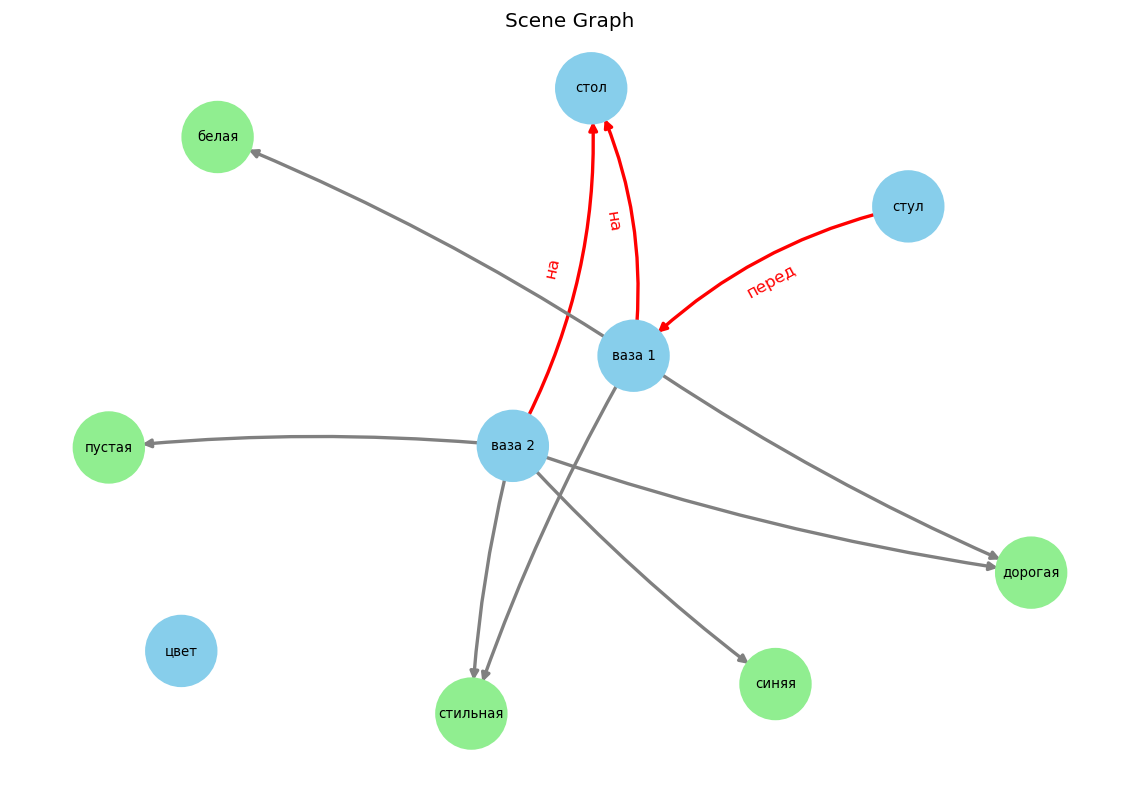

In [10]:
src_text = """
На столе стояла белая ваза с цветами и синяя пустая. Стул находился перед вазой с цветами.Обе вазы 
выглядят очень дорого и стильно
"""
print("Исходный текст:", src_text)

text = normalize_scene_text(src_text, PROMPT, API_KEY)
objects = extract_objects(text)
attributes = extract_attributes(text, objects)
relations  = extract_spatial_relations(text, objects)

print("Нормализованный текст:", text)
print("Объекты:", objects)
print("Признаки:", attributes)   
print("Отношения:", relations)   

G = build_scene_graph(objects, attributes, relations)
draw_scene_graph(G)